<a href="https://colab.research.google.com/github/HarlinLee/BlobOT/blob/main/continuum_gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/BlobOT-final"
import sys
sys.path.append(DRIVE_PATH)
import torch
import numpy as np
import matplotlib.pyplot as plt

import datetime
date = datetime.datetime.today().strftime("%y%m%d")
print(date)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
230529


In [ ]:
def get_grid_samples(nx):
  coords = [(0, 1), (2, 3)]
  dats = []

  for coord in coords:
    y1s, y2s = np.meshgrid(np.linspace(coord[0], coord[1], nx), np.linspace(coord[0], coord[1], nx), indexing='ij')
    dat = []

    for i in range(nx):
      for j in range(nx):
        dat.append(np.array([y1s[i, j], y2s[i, j]]))

    dats.append(np.squeeze(np.array(dat)))
  
  return dats

def plot_2d_paths(X, w, z, params=None):
  fig, ax = plt.subplots(1, 2, figsize=(2*5, 5))
  
  y = X[:,:,-1]
  
  if X.shape[-1] <= params['L']:
    X = np.concatenate((np.expand_dims(z, axis=-1), X), axis=-1)

  for p in range(X.shape[0]):
    traj = X[p].T
    ax[0].plot(traj[:, 0], traj[:, 1],  color=[.5, .5, 1])
  
  ax[0].scatter(X[:, 0, 0], X[:, 1, 0], marker='+', c='b')
  ax[0].scatter(w[:, 0], w[:, 1], marker='x', c='r')

  z = X[:, :, 0]
  ax[1].scatter(z[:, 0], z[:, 1], marker='+', c='b', label='Source')
  ax[1].scatter(w[:, 0], w[:, 1], marker='x', c='r', label='Target')
  ax[1].scatter(y[:, 0], y[:, 1], marker='.', c='k', label='x(1)')

  if params is not None and 'sigma' in params:
    circlew = plt.Circle((params['center'][0], params['center'][1]), params['sigma'], fill=False, edgecolor='r', alpha=0.3)
    ax[1].add_patch(circlew)
  
  tick_kwarg = dict(labelsize=16)
  kwarg = dict(fontsize=24)
  leg_kwarg = dict(fontsize=16, markerscale=2)

  ax[1].set_xticks([])
  ax[1].set_yticks([])

  ax[0].xaxis.set_tick_params(**tick_kwarg)
  ax[0].yaxis.set_tick_params(**tick_kwarg)

  ax[1].legend(**leg_kwarg)

  # share x, y axis
  ylims = np.array([a.get_ylim() for a in ax])
  xlims = np.array([a.get_xlim() for a in ax])
  for cell in ax:
    cell.set_ylim((ylims.min(axis=0)[0], ylims.max(axis=0)[1]))
    cell.set_xlim((xlims.min(axis=0)[0], xlims.max(axis=0)[1]))

  plt.tight_layout(pad=0)
  plt.savefig(os.path.join(DRIVE_PATH, f'2D_example_gaussian_{date}.pdf'), dpi=300)
  plt.show()

In [ ]:
from BlobOT import KE, NLE_gauss, NLE, Model
from BlobOT import draw_straight_lines, EarlyStopping, endpoint_cost, allpoint_cost

def blobGaussianLoss(X, model):
  ke = KE(X, model.z, model.params)
  nle = NLE_gauss(X, model.w, model.params)

  return ke + nle

def blobLoss(X, model):
  ke = KE(X, model.z, model.params)
  nle = NLE(X, model.w, model.params)

  return ke + nle

def training_loop(model, optimizer, lossF, n=10000):
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,
                                                         patience=2, threshold=0,
                                                         factor=0.2)
  early_stopping = EarlyStopping(patience=5)

  losses=[]

  for i in range(n):
    preds = model()
    loss = lossF(preds, model) 

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step(loss)
    early_stopping(loss)
    losses.append(loss.detach())

    if early_stopping.early_stop:
      print("Early stopping at", i, 'out of', n)
      return losses

  return losses

                            

{'N': 225, 'd': 2, 'dt': 0.25, 'L': 4, 'center': [1.5, 1.5], 'lr': 0.0001, 'n': 5000000, 'eps': 0.01, 'delta': 0.06849670075111514, 'sigma': 0.5}


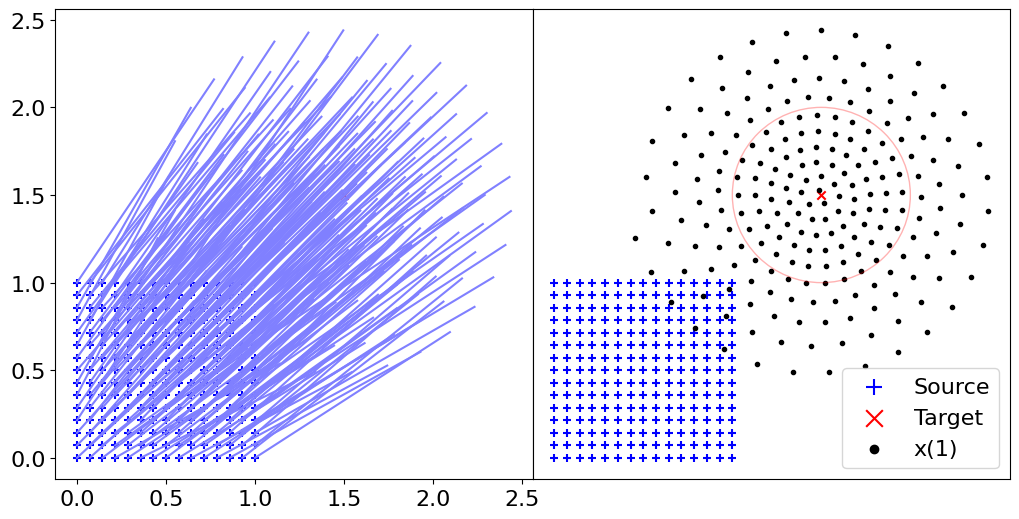

Epoch 4210152: reducing learning rate of group 0 to 2.0000e-05.
Epoch 4210162: reducing learning rate of group 0 to 4.0000e-06.
Early stopping at 4210163 out of 5000000


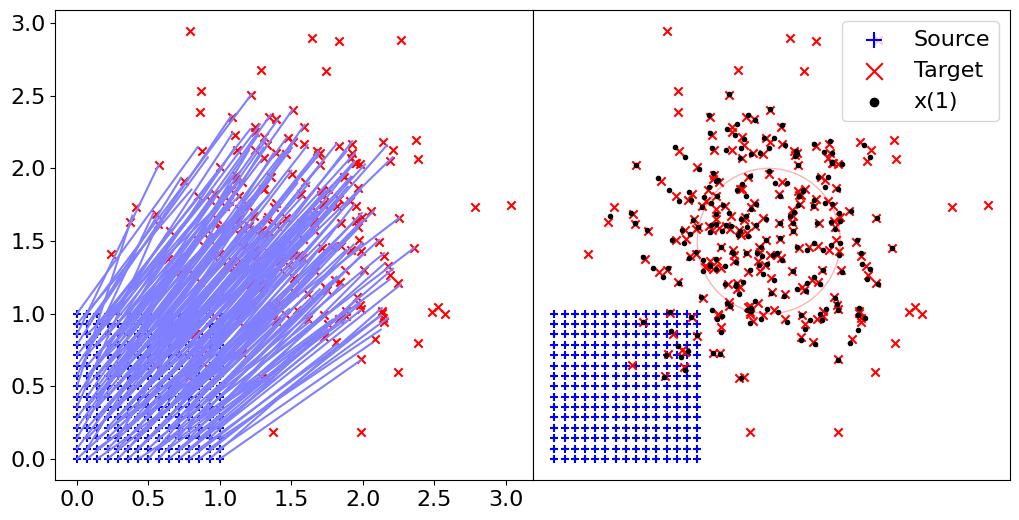

In [4]:
rng = np.random.RandomState(23)

nx = 15
N = nx**2

d = 2
dt = 0.25
L = int(1/dt)

sigma = 0.5

params = {'N': N, 'd': d, 'dt': dt, 'L': L}

params['center'] = [1.5, 1.5]

eps = 1e-2
lr = eps/1e2
gd_steps = 5*int(1e6)
delta = N**(-0.99/d)

params.update({'lr': lr, 'n': gd_steps, 'eps': eps, 'delta': delta, 'sigma': sigma})

print(params)

z, _ = get_grid_samples(nx)
z_tensor = torch.tensor(z)

# initialize to center of target distribution

# Continuum (blobGaussianLoss)
w = np.array(params['center']).reshape(-1, d)
w_tensor = torch.tensor(w)

y0 = np.tile(params['center'], [N, 1])
X0 = draw_straight_lines(z, y0, params['L']+1)

m = Model(torch.from_numpy(X0), w_tensor, z_tensor, params)
opt = torch.optim.SGD(m.parameters(), lr=params['lr'])
losses = training_loop(m, opt, blobGaussianLoss, n=params['n'])

X = m.X.data.cpu().detach().numpy()

plot_2d_paths(X, w, z, params=params)

np.savez(os.path.join(DRIVE_PATH, f'2D_example_gaussian_continuum_{date}.npz'), w=w, z=z, X=X, params=params)

# Samples (blobLoss)
w = sigma*np.random.randn(N, d)+1.5
w_tensor = torch.tensor(w)

y0 = np.tile(np.mean(w, axis=0), [N, 1])
X0 = draw_straight_lines(z, y0, params['L']+1)

m = Model(torch.from_numpy(X0), w_tensor, z_tensor, params)
opt = torch.optim.SGD(m.parameters(), lr=params['lr'])
losses = training_loop(m, opt, blobLoss, n=params['n'])

X = m.X.data.cpu().detach().numpy()

plot_2d_paths(X, w, z, params=params)

np.savez(os.path.join(DRIVE_PATH, f'2D_example_gaussian_{date}.npz'), w=w, z=z, X=X, params=params)

# Plotting

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_2d_paths(X, w, z, params=None, ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(2*5, 5))
  
  y = X[:,:,-1]
  
  if X.shape[-1] <= params['L']:
    X = np.concatenate((np.expand_dims(z, axis=-1), X), axis=-1)

  for p in range(X.shape[0]):
    traj = X[p].T
    ax[0].plot(traj[:, 0], traj[:, 1],  color=[.5, .5, 1])
  
  ax[0].scatter(X[:, 0, 0], X[:, 1, 0], marker='+', c='b')
  ax[0].scatter(w[:, 0], w[:, 1], marker='x', c='r')

  z = X[:, :, 0]
  ax[1].scatter(z[:, 0], z[:, 1], marker='+', c='b', label='Source')
  ax[1].scatter(w[:, 0], w[:, 1], marker='x', c='r', label='Target')
  ax[1].scatter(y[:, 0], y[:, 1], marker='.', c='k', label='x(1)')

  if params is not None and 'sigma' in params:
    circlew = plt.Circle((params['center'][0], params['center'][1]), params['sigma'], fill=False, linestyle='--', edgecolor='r', alpha=0.3)
    ax[1].add_patch(circlew)

    circlew = plt.Circle((params['center'][0], params['center'][1]), 2*params['sigma'], fill=False, linestyle='--', edgecolor='r', alpha=0.3)
    ax[1].add_patch(circlew)
  
  tick_kwarg = dict(labelsize=16)
  kwarg = dict(fontsize=24)
  leg_kwarg = dict(fontsize=16, markerscale=2)

  ax[1].set_xticks([])
  ax[1].set_yticks([])

  ax[0].xaxis.set_tick_params(**tick_kwarg)
  ax[0].yaxis.set_tick_params(**tick_kwarg)

  ax[1].legend(**leg_kwarg)

  # share x, y axis
  ylims = np.array([a.get_ylim() for a in ax])
  xlims = np.array([a.get_xlim() for a in ax])
  for cell in ax:
    cell.set_ylim((ylims.min(axis=0)[0], ylims.max(axis=0)[1]))
    cell.set_xlim((xlims.min(axis=0)[0], xlims.max(axis=0)[1]))

['w', 'z', 'X', 'params']
{'N': 225, 'd': 2, 'dt': 0.25, 'L': 4, 'center': [1.5, 1.5], 'lr': 0.0001, 'n': 5000000, 'eps': 0.01, 'delta': 0.06849670075111514, 'sigma': 0.5}
['w', 'z', 'X', 'params']
{'N': 225, 'd': 2, 'dt': 0.25, 'L': 4, 'center': [1.5, 1.5], 'lr': 0.0001, 'n': 5000000, 'eps': 0.01, 'delta': 0.06849670075111514, 'sigma': 0.5}


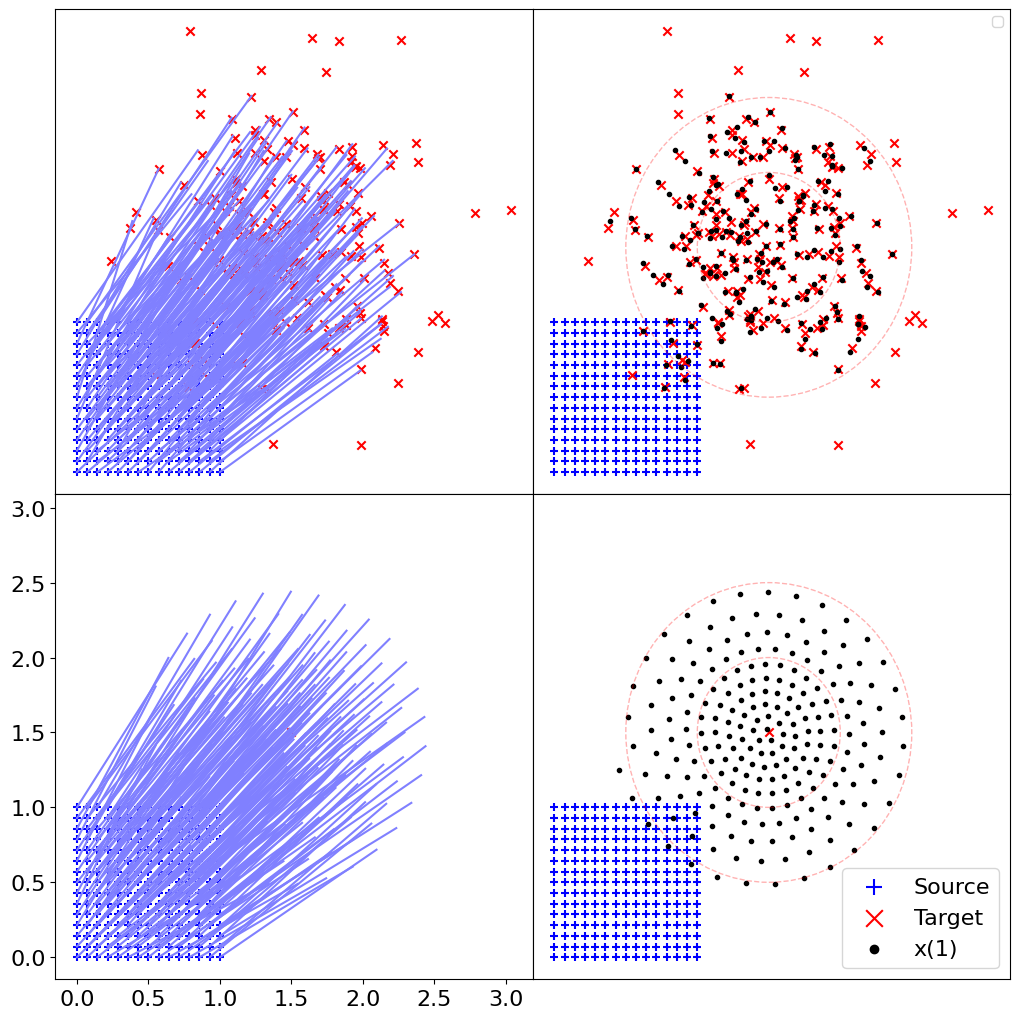

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(2*5, 2*5))

with np.load(os.path.join(DRIVE_PATH, f'2D_example_gaussian_{date}.npz'), allow_pickle=True) as data:
    print(data.files)
    w = data['w']
    z = data['z']
    X = data['X']
    params = data['params'][()]
    print(params)

    plot_2d_paths(X, w, z, params, ax[0, :])

with np.load(os.path.join(DRIVE_PATH, f'2D_example_gaussian_continuum_{date}.npz'), allow_pickle=True) as data:
    print(data.files)
    w = data['w']
    z = data['z']
    X = data['X']
    params = data['params'][()]
    params['center'] = [1.5, 1.5]
    print(params)

    plot_2d_paths(X, w, z, params, ax[1, :])


ylims = np.array([a.get_ylim() for a in ax.flatten()])
xlims = np.array([a.get_xlim() for a in ax.flatten()])
for cell in ax.flatten():
  cell.set_ylim((ylims.min(axis=0)[0], ylims.max(axis=0)[1]))
  cell.set_xlim((xlims.min(axis=0)[0], xlims.max(axis=0)[1]))

ax[0, 0].set_xticks([])
ax[0, 0].set_yticks([])

ax[0, 1].legend([])

plt.tight_layout(pad=0)
plt.savefig(os.path.join(DRIVE_PATH, f'2D_example_gaussian_full_{date}.pdf'), dpi=300)
plt.show()